In [1]:
import pandas as pd
from datetime import datetime

In [8]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

In [154]:
dataset = pd.read_csv("/Users/houzhuo/Downloads/pm.csv", parse_dates = [['year', 'month', 'day', 'hour']], index_col=0,date_parser=parse)
dataset['pm2.5'][35040]

84.0

In [58]:
dataset.drop('No', axis=1, inplace=True)

In [59]:
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

In [60]:
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [61]:
# save to file
dataset.to_csv('pollution.csv')

In [62]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 8,6 # Big graphs unless specified
sns.set(color_codes=True) # Set style and color of graphs

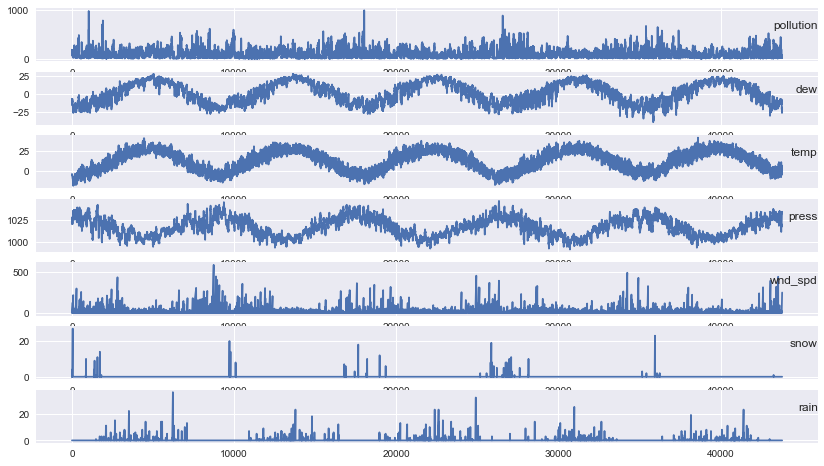

In [63]:
# load dataset
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i=1
plt.figure(figsize=(14,8))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [64]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [65]:
from sklearn import preprocessing 
# load dataset
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])#把第四列的文字变成label编码，几个类就几个label
# ensure all data is float
values = values.astype('float32')


In [75]:
# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())#这里的最后一列就是第一列往后延了一个t

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545455   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563636   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563636   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [111]:
reframed.shape

(43799, 9)

In [114]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [115]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]#y是最后一列
test_X, test_y = test[:, :-1], test[:, -1]

In [116]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [155]:
test_y

array([[0.03118712],
       [0.02012072],
       [0.01911469],
       ...,
       [0.01006036],
       [0.00804829],
       [0.01207243]])

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 2s - loss: 0.0625 - val_loss: 0.0556
Epoch 2/50
 - 1s - loss: 0.0428 - val_loss: 0.0630
Epoch 3/50
 - 1s - loss: 0.0273 - val_loss: 0.0548
Epoch 4/50
 - 1s - loss: 0.0198 - val_loss: 0.0471
Epoch 5/50
 - 1s - loss: 0.0170 - val_loss: 0.0350
Epoch 6/50
 - 1s - loss: 0.0155 - val_loss: 0.0217
Epoch 7/50
 - 1s - loss: 0.0150 - val_loss: 0.0174
Epoch 8/50
 - 1s - loss: 0.0148 - val_loss: 0.0167
Epoch 9/50
 - 1s - loss: 0.0148 - val_loss: 0.0158
Epoch 10/50
 - 1s - loss: 0.0147 - val_loss: 0.0151
Epoch 11/50
 - 1s - loss: 0.0147 - val_loss: 0.0145
Epoch 12/50
 - 1s - loss: 0.0146 - val_loss: 0.0144
Epoch 13/50
 - 1s - loss: 0.0146 - val_loss: 0.0143
Epoch 14/50
 - 1s - loss: 0.0146 - val_loss: 0.0141
Epoch 15/50
 - 1s - loss: 0.0146 - val_loss: 0.0138
Epoch 16/50
 - 1s - loss: 0.0145 - val_loss: 0.0143
Epoch 17/50
 - 1s - loss: 0.0147 - val_loss: 0.0139
Epoch 18/50
 - 1s - loss: 0.0146 - val_loss: 0.0140
Epoch 19/50
 - 1s - loss

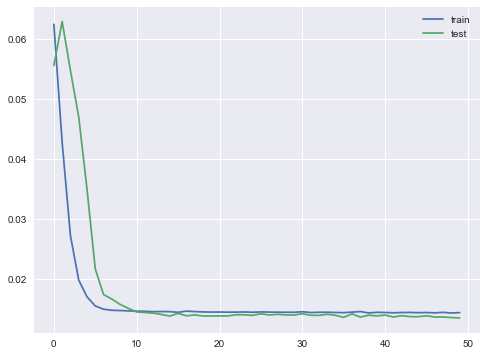

In [121]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [122]:
from math import sqrt
from numpy import concatenate
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))#(35039, 1, 8)->(35039, 8)

In [137]:
inv_yhat.shape

(35039,)

In [146]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)#(35039, )+(35039, 7)
inv_yhat = scaler.inverse_transform(inv_yhat)#把数据转回到之前的尺度
inv_yhat = inv_yhat[:,0]
inv_yhat

array([35.19100988, 31.54936977, 20.90473041, ...,  8.69804437,
        8.67973241,  6.8581764 ])

In [158]:


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
inv_y

array([31., 20., 19., ..., 10.,  8., 12.])

In [159]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.531


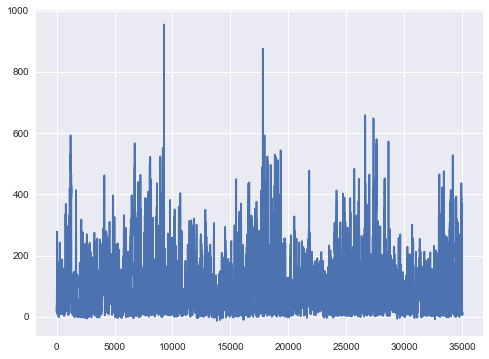

In [160]:
plt.plot(inv_yhat)
plt.show()

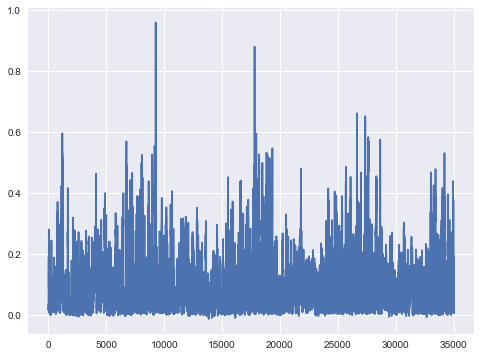

In [143]:
plt.plot(yhat)
plt.show()